Comparing both methods, annotate which cell was specific for a Method or overlap and then do normal CLuster workflow to show if ED identified e.g. Muscle Clusters. 

In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import json
import os

# Load color scheme from JSON file (located in project root)
colorcodes_path = '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/colorcodes.json'

# Load colors
with open(colorcodes_path, 'r') as f:
    colorcodes = json.load(f)

# Extract algorithm colors for plotting
# detection_method: 0 = CellRanger only, 1 = EmptyDrops only, 2 = Both
ALGO_COLORS = {
    0: colorcodes['algorithms']['cellranger']['hex'],  # CellRanger brown
    1: colorcodes['algorithms']['pyED']['hex'],        # EmptyDrops (pyED) yellow
    2: colorcodes['algorithms']['intersection_pyED_CR']['hex']  # Both (intersection) orange-brown
}

print(f"Loaded color scheme from: {colorcodes_path}")
print(f"CellRanger color: {ALGO_COLORS[0]}")
print(f"EmptyDrops color: {ALGO_COLORS[1]}")
print(f"Intersection color: {ALGO_COLORS[2]}")

#assays = sc.read_10x_h5("53_results_clusters/decontx_with_clusters_SCEh5/assays.h5")
aCellRanger = sc.read_10x_h5("../data/filtered_feature_bc_matrix.h5")
bEmptyDrops = sc.read_h5ad("../data/old/emptydrops_all_detected_cells.h5ad")
aEmptyDrops = sc.read_h5ad("../data/pyED_correct.h5ad")

Loaded color scheme from: /Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/colorcodes.json
CellRanger color: #929a65
EmptyDrops color: #FFCF3E
Intersection color: #33cccc


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


do union on cellranger and emptydrops -> union anndata objects along the obs axis (var = genes, obs = cells)

In [7]:
# Check how many FDR values there are in the FDR column
if 'FDR' in aEmptyDrops.obs.columns:
    num_fdr_values = aEmptyDrops.obs['FDR'].notnull().sum()
    print(f"Number of non-null FDR values in aEmptyDrops: {num_fdr_values}")
else:
    print("FDR column not found in aEmptyDrops.obs")

Number of non-null FDR values in aEmptyDrops: 8202


In [8]:
print(f"CR shape: {aCellRanger.X.shape}")
print(f"ED shape: {aEmptyDrops.X.shape}")

# Get barcodes from both datasets
cellranger_barcodes = set(aCellRanger.obs.index)
emptydrops_barcodes = set(aEmptyDrops.obs.index)

# Find unique and overlapping barcodes
overlap_barcodes = cellranger_barcodes.intersection(emptydrops_barcodes)
cellranger_only = cellranger_barcodes - overlap_barcodes
emptydrops_only = emptydrops_barcodes - overlap_barcodes

print(f"CellRanger only: {len(cellranger_only)}")
print(f"EmptyDrops only: {len(emptydrops_only)}")
print(f"Overlap: {len(overlap_barcodes)}")

# Create union by taking all unique cells from both datasets
# For overlapping cells, we'll take them from CellRanger (arbitrary choice)
union_barcodes = list(cellranger_only) + list(emptydrops_only) + list(overlap_barcodes)

# Subset datasets to get the union components
cellranger_subset = aCellRanger[aCellRanger.obs.index.isin(cellranger_only | overlap_barcodes)].copy()
emptydrops_subset = aEmptyDrops[aEmptyDrops.obs.index.isin(emptydrops_only)].copy()

# Add detection method annotation
# 0 = CellRanger only, 1 = EmptyDrops only, 2 = Both
cellranger_subset.obs['detection_method'] = 0  # CellRanger only
cellranger_subset.obs.loc[cellranger_subset.obs.index.isin(overlap_barcodes), 'detection_method'] = 2  # Both
emptydrops_subset.obs['detection_method'] = 1  # EmptyDrops only

# Make variable names unique to avoid concatenation issues
cellranger_subset.var_names_make_unique()
emptydrops_subset.var_names_make_unique()

# Concatenate to create union
adata = ad.concat([cellranger_subset, emptydrops_subset], join='outer')
print(f"Union shape: {adata.X.shape}")

# Save the union dataset as h5ad file
adata.write_h5ad("union_cellranger_emptydrops.h5ad")
print("Saved union dataset as union_cellranger_emptydrops.h5ad")

adata.obs

CR shape: (2701, 22040)
ED shape: (8202, 22040)
CellRanger only: 35
EmptyDrops only: 5536
Overlap: 2666
Union shape: (8237, 22040)
Saved union dataset as union_cellranger_emptydrops.h5ad


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,detection_method,Total,PValue,Limited,LogProb,FDR
AAACAGCCAGTCTAGC-1,2,NaN,NaN,<NA>,NaN,NaN
AAACCAACACAGGGAC-1,2,NaN,NaN,<NA>,NaN,NaN
AAACCGAAGCTAAAGG-1,2,NaN,NaN,<NA>,NaN,NaN
AAACCGCGTAAAGCAA-1,2,NaN,NaN,<NA>,NaN,NaN
AAACCGCGTCCGTGAG-1,2,NaN,NaN,<NA>,NaN,NaN
...,...,...,...,...,...,...
TTTGTGTTCTTGCAGG-1,1,6206.0,0.0001,True,-12947.977994,0.000226
TTTGTTGGTCACAGAC-1,1,2869.0,0.0001,True,-9640.391134,0.000226
TTTGTTGGTGCTTTAC-1,1,1134.0,0.0001,True,-2986.512009,0.000226
TTTGTTGGTTAGGTGC-1,1,1268.0,0.0001,True,-3161.103808,0.000226


# test new function for gene_pathway_analyzer.py

In [9]:
bool_hvg = True

# Select 3000 highly variable genes (HVGs), robust against numpy/skmisc binary-incompat errors
if bool_hvg:
    try:
        sc.pp.highly_variable_genes(
            adata, n_top_genes=3000, subset=True, flavor='seurat'
        )
    except ValueError as ve:
        # Known binary compatibility error with skmisc (loess) or data-related error
        if (
            "numpy.dtype size changed" in str(ve)
            or "cannot specify integer `bins`" in str(ve)
            or "skmisc" in str(ve)
        ):
            raise RuntimeError(
                "The 'seurat_v3' HVG selection failed due to a numpy/scikit-misc binary incompatibility "
                "or data containing infinity/NaN values. "
                "Try reinstalling numpy and scikit-misc compatible versions, or filter/normalize your data to remove inf/NaN values."
                f"\nOriginal error: {ve}"
            )
        else:
            raise

# Normalization and log1p already assumed done above; skip scaling as per instructions

# Principal Component Analysis (PCA)
sc.tl.pca(adata, n_comps=50, svd_solver="arpack")

# Build the neighborhood graph optimized for trajectory structure
sc.pp.neighbors(
    adata,
    n_neighbors=50,
    n_pcs=50,
    method="umap"  # matches reference structure; use default/umap
)

# UMAP embedding for visualization
sc.tl.umap(
    adata,
    min_dist=0.1,      # tighter, condensed paths
    spread=0.6,        # narrow/linear structure
    n_components=2,
    random_state=42,
    #negative_sample_rate=10  # option for linear trajectories, omitted here
)

# Leiden clustering with multiple resolutions
resolutions = [0.9]
for res in resolutions:
    sc.tl.leiden(
        adata,
        resolution=res,
        flavor="igraph",
        n_iterations=2,
        directed=False,
        key_added=f'leiden_{res}'
    )

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scipy/sparse/_data.py:149: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_highly_variable_genes.py:297: RuntimeWarning: overflow encountered in expm1
  X = np.expm1(X)


RuntimeError: The 'seurat_v3' HVG selection failed due to a numpy/scikit-misc binary incompatibility or data containing infinity/NaN values. Try reinstalling numpy and scikit-misc compatible versions, or filter/normalize your data to remove inf/NaN values.
Original error: cannot specify integer `bins` when input data contains infinity


COMPARING CELLRANGER AND EMPTYDROPS
Found 35x CellRanger only cells
Found 5536x EmptyDrops only cells
Found 2666x detected by both methods cells


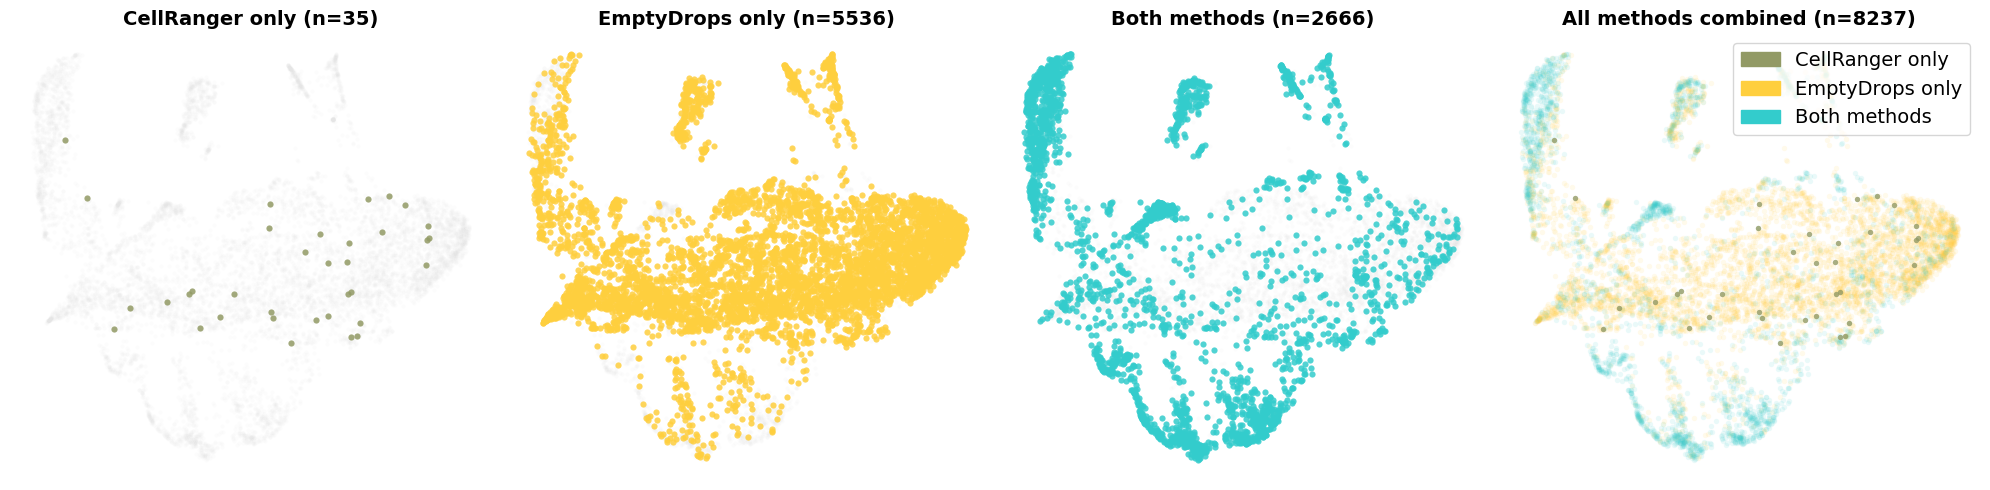

In [ ]:
CREDcomparison = True

if CREDcomparison:
    print(f"\nCOMPARING CELLRANGER AND EMPTYDROPS")
    
    # Check if we got the union with the added column "detection_method", otherwise throw an error and check if there are only 0,1 and 2 values in the column
    if 'detection_method' not in adata.obs.columns:
        raise ValueError("Detection method column not found, no union provided, cannot proceed with comparison")
    if not all(adata.obs['detection_method'].isin([0,1,2])):
        raise ValueError("Detection method column contains invalid values, be sure only 0,1 and 2 values are present")
    
    # Print the number of cells for each detection method
    print(f"Found {len(adata.obs[adata.obs['detection_method'] == 0])}x CellRanger only cells")
    print(f"Found {len(adata.obs[adata.obs['detection_method'] == 1])}x EmptyDrops only cells")
    print(f"Found {len(adata.obs[adata.obs['detection_method'] == 2])}x detected by both methods cells")

    # create plots to show the difference between the two methods. Use ALGO_COLORS for ALL first 3 plots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    method_names = ['CellRanger only', 'EmptyDrops only', 'Both methods', 'All methods combined']
    detection_method_colors = ALGO_COLORS  # {0: CellRanger brown, 1: pyED yellow, 2: intersection orange-brown}
    
    for i, (method_val, name) in enumerate(zip([0, 1, 2], method_names[:3])):
        mask = adata.obs['detection_method'] == method_val
        # Plot "background" all cells lightly in gray for context
        axes[i].scatter(
            adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1],
            c="#E5E5E5", s=8, alpha=0.1, linewidths=0
        )
        if mask.sum() > 0:
            axes[i].scatter(
                adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1],
                c=detection_method_colors[method_val], s=20, alpha=0.85, linewidths=0, label=name
            )
        suffix = " (HVGs)" if bool_hvg else ""
        axes[i].set_title(f'{name} (n={mask.sum()}){suffix}', fontsize=14, fontweight='bold')
        # remove frameon
        axes[i].set_frame_on(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    # Fourth plot: All methods combined with different colors
    # Plot points in order ED only (1), Both methods (2), CellRanger only (0) so that CR lays on top
    plot_order = [1, 2, 0]
    for method_val in plot_order:
        mask = adata.obs['detection_method'] == method_val
        if mask.sum() > 0:
            color = detection_method_colors[method_val]
            # Set alpha to 0.8 explicitly for CR only, rest is 0.1 
            alpha_val = 0.8 if method_val == 0 else 0.1
            axes[3].scatter(
                adata.obsm['X_umap'][mask, 0], adata.obsm['X_umap'][mask, 1],
                c=color, s=15, alpha=alpha_val, linewidths=0
            )
    import matplotlib.patches as mpatches
    cr_patch = mpatches.Patch(color=ALGO_COLORS[0], label=f'CellRanger only')
    ed_patch = mpatches.Patch(color=ALGO_COLORS[1], label=f'EmptyDrops only')
    both_patch = mpatches.Patch(color=ALGO_COLORS[2], label=f'Both methods')
    # bold and fontsize 14 in legend
    legend_properties = {'size':14}
    axes[3].legend(handles=[cr_patch, ed_patch, both_patch], loc='upper right', prop=legend_properties)
    axes[3].set_title(f'{method_names[3]} (n={len(adata)})')
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    axes[3].set_frame_on(False)
    # title bold and fontsize 14
    axes[3].set_title(f'{method_names[3]} (n={len(adata)})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    # !!!!!!!! add output_dir/
    if bool_hvg:
        plt.savefig(f"cellranger_emptydrops_comparison_hvg2.pdf", dpi=300, bbox_inches='tight')
    else:
        plt.savefig(f"cellranger_emptydrops_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.show()

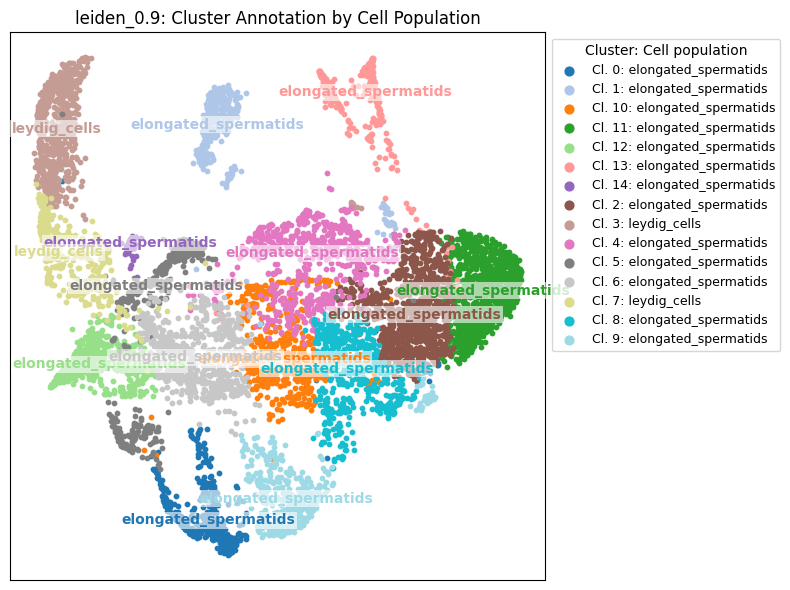

In [ ]:
# Map clusters to top **cell population** (not marker gene) based on expression, using pre-defined marker genes per cell population

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

# --- Define population marker genes (from gene_pathway_analysis.py lines 98-139) ---
cell_population_markers = {
    # spermatogonia
    'spermatogonia': [
        'ID4', 'GFRA1', 'ZBTB16', 'NANOS2', 'UTF1', 'SALL4',
        'DMRT1', 'SOHLH1', 'SOHLH2'
    ],
    # spermatocyten
    'spermatocytes': [
        'STRA8', 'DMRT6', 'SYCP1', 'SYCP2', 'SYCP3', 'HORMAD1', 'HORMAD2', 'TEX101', 'MLH1'
    ],
    # spermatiden (rund)
    'round_spermatids': [
        'TNP1', 'TNP2', 'ACRV1', 'CRISP2', 'GSTM3', 'SPATA16'
    ],
    # spermatiden (elongating/condensed)
    'elongated_spermatids': [
        'PRM1', 'PRM2', 'TNP1', 'TNP2', 'GSTM3', 'CRISP2', 'OAZ3', 'SPATA16'
    ],
    # leydig zellen
    'leydig_cells': [
        'CYP17A1', 'CYP11A1', 'HSD3B1', 'HSD17B3', 'STAR', 'INSL3', 'NR5A1', 'PDGFRA', 'NR2F2'
    ],
    # sertoli zellen
    'sertoli_cells': [
        'SOX9', 'AMH', 'GATA4', 'WT1', 'INHA', 'CLDN11', 'VIM', 'TF', 'RBP1', 'FSHR'
    ],
    # peritubular zellen
    'peritubular_cells': [
        'ACTA2', 'MYH11', 'CNN1', 'TAGLN', 'PDGFRB', 'DES', 'CSPG4'
    ]
}

leiden_cols = sorted([col for col in adata.obs.columns if col.startswith("leiden")])
if not leiden_cols:
    raise ValueError("No leiden clusters found in adata.obs. Please run sc.tl.leiden first with desired resolutions.")

if hasattr(adata, "raw") and adata.raw is not None:
    expr = adata.raw.X
    genes = np.asarray(adata.raw.var_names)
else:
    expr = adata.X
    genes = np.asarray(adata.var_names)

# Build gene index lookup
gene2idx = {g: i for i, g in enumerate(genes)}

# Check unique gene names
if pd.Series(genes).duplicated().any():
    print("Warning: gene names are not unique. This may affect marker assignment.")

for leiden_key in leiden_cols:
    leiden_labels = adata.obs[leiden_key].astype(str).values
    clusters = np.unique(leiden_labels)
    cluster2cellpop = {}
    cluster2cellpop_score = defaultdict(dict)  # For debug: store scores

    for cl in clusters:
        mask = (leiden_labels == cl)
        # Compute mean expression per gene in this cluster
        if hasattr(expr, "toarray"):
            mean_expr = np.array(expr[mask, :].mean(axis=0)).flatten()
        else:
            mean_expr = np.array(expr[mask, :].mean(axis=0)).flatten()
        
        # For each population, compute mean marker gene expression (only use genes present in data)
        pop_scores = {}
        for pop, markers in cell_population_markers.items():
            idxs = [gene2idx[g] for g in markers if g in gene2idx]
            if idxs:
                pop_scores[pop] = float(np.mean(mean_expr[idxs]))
            else:
                pop_scores[pop] = float('-inf')  # No markers available
        # Assign cluster to the population with highest score
        best_pop = max(pop_scores, key=pop_scores.get)
        cluster2cellpop[cl] = best_pop
        cluster2cellpop_score[cl] = pop_scores  # Optionally for debug

    # Plot UMAP with cluster assignment named by cell population
    umap = adata.obsm["X_umap"]
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))
    color_map = {cl: colors[i] for i, cl in enumerate(clusters)}

    for cl in clusters:
        mask = (leiden_labels == cl)
        label = f"Cl. {cl}: {cluster2cellpop[cl]}"
        ax.scatter(umap[mask, 0], umap[mask, 1], s=10, color=color_map[cl], label=label)
    
    # Annotate cluster centers with population name
    for cl in clusters:
        mask = (leiden_labels == cl)
        x_median = np.median(umap[mask, 0])
        y_median = np.median(umap[mask, 1])
        ax.text(
            x_median, y_median, cluster2cellpop[cl], fontsize=10, fontweight='bold',
            color=color_map[cl], ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{leiden_key}: Cluster Annotation by Cell Population")
    ax.legend(markerscale=2, loc='upper left', bbox_to_anchor=(1, 1), fontsize=9, title="Cluster: Cell population")
    plt.tight_layout()
    plt.show()

[255392. 123383. 113387.  92017.  77196.  70265.  69509.  69132.  68681.
  64868.]
Ranks of CellRanger only cells: [2254, 3577, 3942, 4013, 4414, 4577, 4900, 5200, 5562, 5568, 5571, 5642, 5657, 5676, 5845, 5978, 6107, 6283, 6485, 6522, 6644, 6881, 6895, 7036, 7149, 7336, 7468, 7615, 7647, 7675, 7677, 7725, 7726, 7845, 7980]


/var/folders/06/zfzddxwn4hd0ywccb30sl4qw0000gn/T/ipykernel_18318/4097328980.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right', prop=legend_properties)


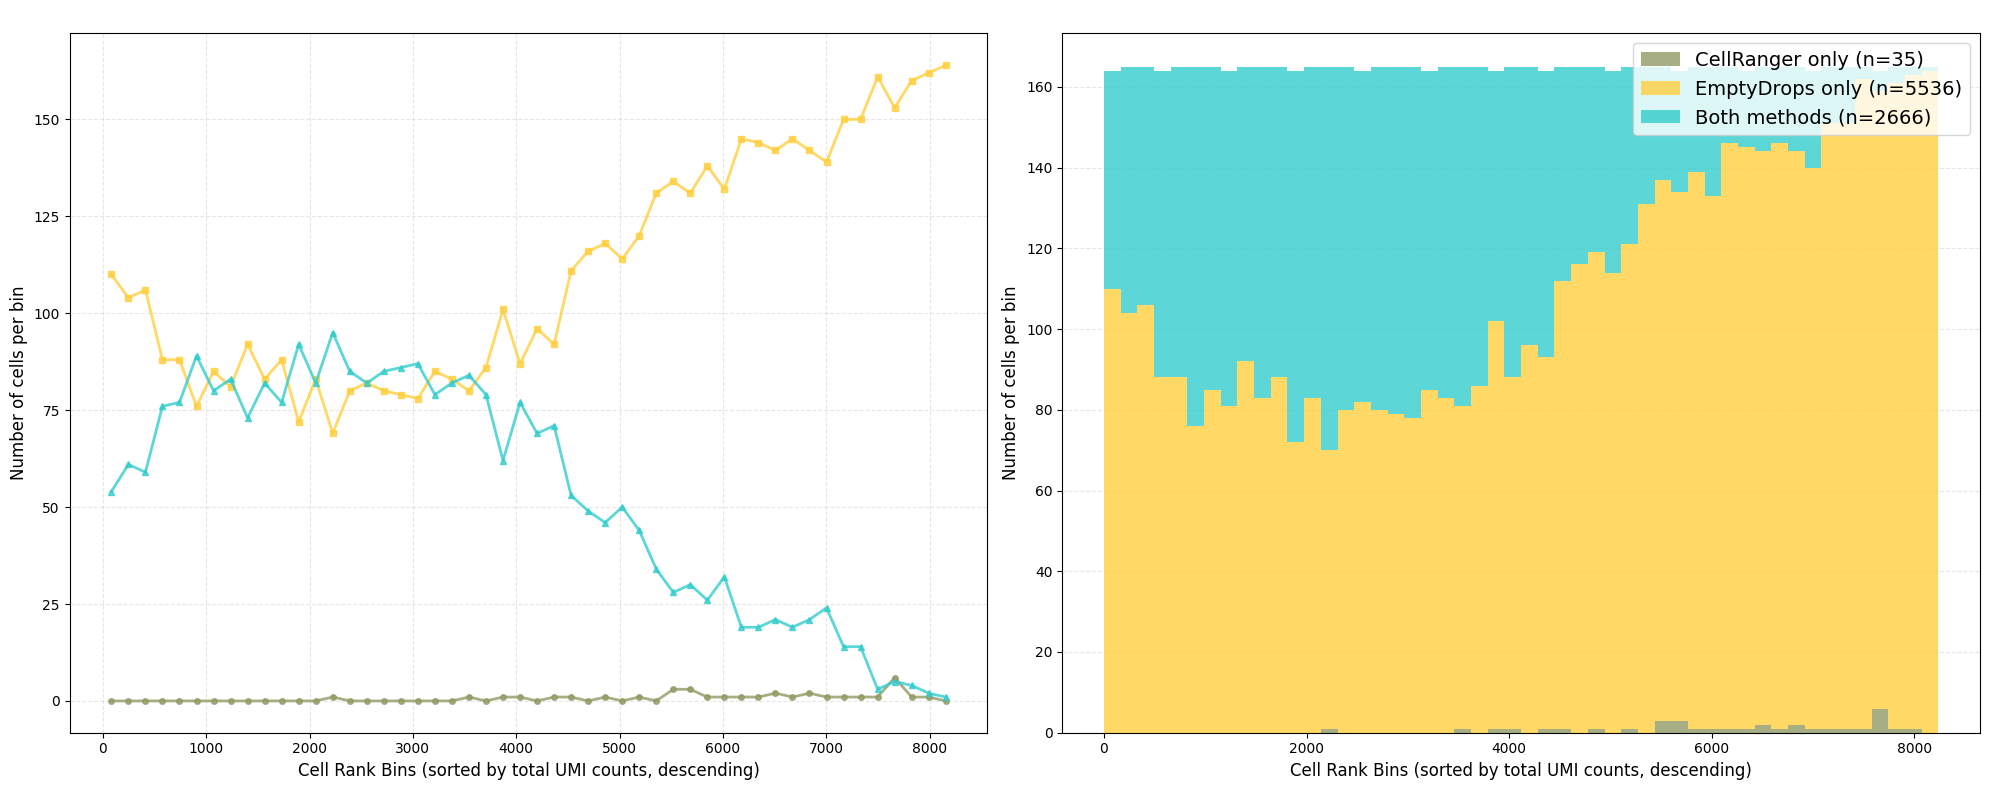

In [ ]:
# Get total counts for each cell and plot it
if 'total_counts' in adata.obs.columns:
    counts = adata.obs['total_counts'].values
else:
    counts = np.array(adata.X.sum(axis=1)).flatten()
detection_methods = adata.obs['detection_method'].values
sorted_indices = np.argsort(counts)[::-1]
sorted_counts = counts[sorted_indices] 
print(sorted_counts[:10])
sorted_methods = detection_methods[sorted_indices] 
# Use colors from colorcodes.json - note: for line plots we use CellRanger brown, pyED yellow, intersection orange-brown
# Using ALGO_COLORS for consistency, but note: EmptyDrops uses yellow (#FFCF3E) not blue in this context
color_map = ALGO_COLORS  # {0: CellRanger brown, 1: pyED yellow, 2: intersection orange-brown} 
line_colors = [color_map[int(m)] for m in sorted_methods]
cr_only_mask = sorted_methods == 0
cr_only_ranks = np.where(cr_only_mask)[0] + 1  # +1 to make ranks 1-based
print(f"Ranks of CellRanger only cells: {cr_only_ranks.tolist()}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
n_bins = 50
bin_edges = np.linspace(0, len(sorted_counts), n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cr_counts = np.zeros(n_bins)
ed_counts = np.zeros(n_bins)
both_counts = np.zeros(n_bins)
for i in range(n_bins):
    start_idx = int(bin_edges[i])
    end_idx = int(bin_edges[i + 1])
    bin_methods = sorted_methods[start_idx:end_idx]
    
    cr_counts[i] = np.sum(bin_methods == 0)
    ed_counts[i] = np.sum(bin_methods == 1)
    both_counts[i] = np.sum(bin_methods == 2)

# Left plot - using colors from colorcodes.json
ax1.plot(bin_centers, cr_counts, color=ALGO_COLORS[0], linewidth=2, alpha=0.8, label=f'CellRanger only (n={np.sum(sorted_methods==0)})', marker='o', markersize=4)
ax1.plot(bin_centers, ed_counts, color=ALGO_COLORS[1], linewidth=2, alpha=0.8, label=f'EmptyDrops only (n={np.sum(sorted_methods==1)})', marker='s', markersize=4)
ax1.plot(bin_centers, both_counts, color=ALGO_COLORS[2], linewidth=2, alpha=0.8, label=f'Both methods (n={np.sum(sorted_methods==2)})', marker='^', markersize=4)
ax1.set_xlabel('Cell Rank Bins (sorted by total UMI counts, descending)', fontsize=12)
ax1.set_ylabel('Number of cells per bin', fontsize=12)
ax1.set_title(' ', fontsize=14, fontweight='bold')
legend_properties = {'weight':'bold', 'size':14}
ax2.legend(loc='upper right', prop=legend_properties)
ax1.grid(axis='both', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Right plot - using colors from colorcodes.json
ax2.bar(bin_centers, cr_counts, color=ALGO_COLORS[0], alpha=0.8, label=f'CellRanger only (n={np.sum(sorted_methods==0)})', width=bin_centers[1]-bin_centers[0])
ax2.bar(bin_centers, ed_counts, bottom=cr_counts, color=ALGO_COLORS[1], alpha=0.8, label=f'EmptyDrops only (n={np.sum(sorted_methods==1)})', width=bin_centers[1]-bin_centers[0])
ax2.bar(bin_centers, both_counts, bottom=cr_counts+ed_counts, color=ALGO_COLORS[2], alpha=0.8, label=f'Both methods (n={np.sum(sorted_methods==2)})', width=bin_centers[1]-bin_centers[0])
ax2.set_xlabel('Cell Rank Bins (sorted by total UMI counts, descending)', fontsize=12)
ax2.set_ylabel('Number of cells per bin', fontsize=12)
ax2.set_title(' ', fontsize=14, fontweight='bold')

legend_properties = {'size':14}
ax2.legend(loc='upper right', prop=legend_properties)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

if bool_hvg:
    plt.savefig(f"cellranger_emptydrops_comparison_stacked_bar_hvg.pdf", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"cellranger_emptydrops_comparison_stacked_bar.pdf", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# RUN GSEA

In [ ]:
import sys
sys.path.insert(1, '/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/GSEA_new')
from gene_pathway_analysis import SpermatogenesisAnalyzer # main file for GSEA analysis. creates h5ad file with GSEA processed data

Output directory created: 4_final_pyED/GSEA_20251112_142147
Defined 27 trajectory markers of germ cells (5 categories)
Cell type markers: 58 total including leydig/sertoli etc
Original data shape: (8237, 22040)
Data loaded and QC metrics calculated


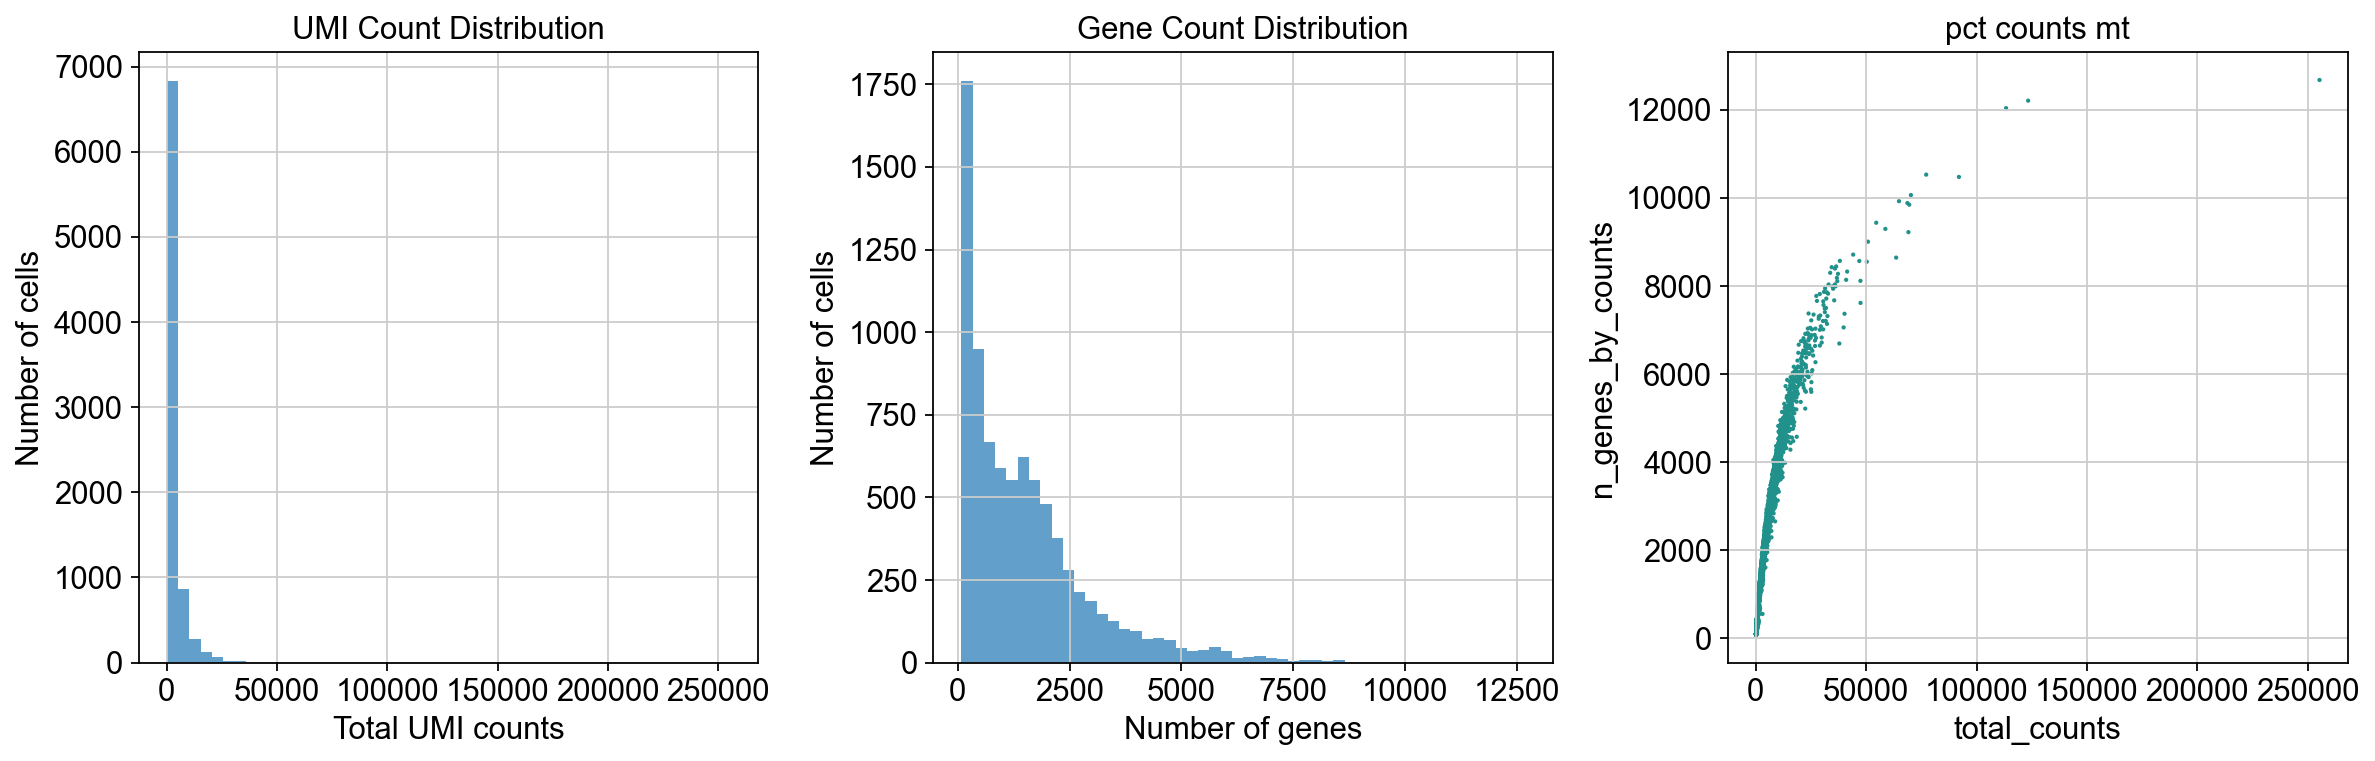


NORMALIZATION & SCALING
Parameters saved to: 4_final_pyED/GSEA_20251112_142147/parameters.txt
NO custom hvg filter but just for your information:
There would be 6012 highly variable genes available

ADVANCED DIMENSIONALITY REDUCTION


Compute diffusion-based UMAP: 100%|██████████| 4/4 [00:59<00:00, 14.82s/step]



SPERMATOGENESIS TRAJECTORY INFERENCE
Root cluster set: 12

GSEA PATHWAY ANALYSIS
Progression groups: progression_group
LATE     4252
EARLY    3985
Name: count, dtype: int64
(1/1) Running GSEA with GO_Biological_Process_2023...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10b136430>>
Traceback (most recent call last):
  File "/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:

SA = SpermatogenesisAnalyzer(data_path='/Users/oskarhaupt/Documents/DE/2024_FU-Bachelor/WS-24-25/Charité/05_sorted/12_ComparisonCR-ED_clustering/union_cellranger_emptydrops.h5ad',
                             output_dir='4_final_pyED', CREDcomparison=True, activate_hvg=bool_hvg)
cdata = SA.run_complete_analysis()